In [13]:
import sys
sys.path.insert(0, "..")

In [14]:
import pickle 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra

from pprint import pp
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import ConstantBounds
from utils.cobra_utils import get_or_create_exchange
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes


# Load model and retrieve exchange reactions
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

In [15]:
with model:
    ex_glc.lower_bound = -10
    glc_sol = model.optimize()

with model:
    ex_ace.lower_bound = -10
    ace_sol = model.optimize()

In [16]:
def get_producing_fluxes(component, fluxes, exclude_precursors=["ATP[c]"]):
    if component.formula is None:  # Recursively get producing flxues for precursors
        # Get precursors
        precursors = []
        for reaction in component.reactions:
            prod_rate = fluxes[reaction.id] * reaction.metabolites[component]
            if prod_rate > 0:
                precursors += [met
                               for met in reaction.metabolites
                               if fluxes[reaction.id] * reaction.metabolites[met] < 0
                               and met.id not in exclude_precursors]
        
        # Get producing fluxes for precursors
        result = {}
        for precursor in precursors:
            precursor_fluxes = get_producing_fluxes(precursor, fluxes)
            for reaction_id, flux in precursor_fluxes.items():
                if reaction_id in result:
                    result[reaction_id] += flux
                else:
                    result[reaction_id] = flux
        return result
    else:
        # Get reactions that produce the component
        producing_reactions = {}
        for reaction in component.reactions:
            prod_rate = fluxes[reaction.id] * reaction.metabolites[component]
            if prod_rate > 0:
                producing_reactions[reaction.id] = prod_rate

        return producing_reactions


component = "PROTEIN[c]"
component = model.metabolites.get_by_id(component)

fluxes = glc_sol.fluxes

# Get reactions that produce the component
get_producing_fluxes(component, fluxes)

{'KYNURENINASE-RXN': 3.1485713103118768e-12,
 'RXN-8': 0.3074294783187237,
 'ARGSUCCINLYA-RXN': 0.17672059917606456,
 'ASNSYNB-RXN': 0.28803607985190594,
 '1.4.1.21-RXN-L-ASPARTATE/NADP/WATER//OXALACETIC_ACID/AMMONIUM/NADPH/PROTON.62.': 6.782469514070123,
 'ASPARTASE-RXN': 2.3485164266022833,
 'ACSERLY-RXN': 0.0551285033341267,
 'L-GLN-FRUCT-6-P-AMINOTRANS-RXN-FRUCTOSE-6P/GLN//CPD-13469/GLT.31.': 0.6792308772051783,
 'CTPSYN-RXN': 0.04642237579564726,
 'FGAMSYN-RXN': 0.12026145755187793,
 'ASPAMINOTRANS-RXN': 7.7141455093661655,
 'GABATRANSAM-RXN': 0.30742947831872364,
 'ANTHRANSYN-RXN': 0.03396078685217005,
 'GLUTAMIDOTRANS-RXN': 0.05660111198005869,
 'PABASYN-RXN': 0.0004810001263071747,
 'PRPPAMIDOTRANS-RXN': 0.12026145755187793,
 'GLYOHMETRANS-RXN': 5.135627613841343,
 'HISTALDEHYD-RXN': 0.056601111980058676,
 'BRANCHED-CHAINAMINOTRANSFERILEU-RXN': 0.17357622580295412,
 'BRANCHED-CHAINAMINOTRANSFERLEU-RXN': 0.2691692416962944,
 'DIAMINOPIMDECARB-RXN': 0.20502115536795643,
 'HOMOCYS

In [17]:
# utility function to get good dimensions for a grid
def nearest_rect(num):
    width = int(num**0.5)
    height = num // width
    while width * height != num:
        width += 1
        height = num // width
    return width, height

# utility function to convert a name to a color
def name_to_color(name, N = 17):
    theta_1 = (hash(name) % N) / N
    theta_2 = (hash(theta_1) % N) / N
    theta_3 = (hash(theta_2) % N) / N

    h = theta_1
    s = 0.6 + 0.4 * theta_2
    v = 0.5 + 0.4 * theta_3
    return matplotlib.colors.hsv_to_rgb([h,s,v])

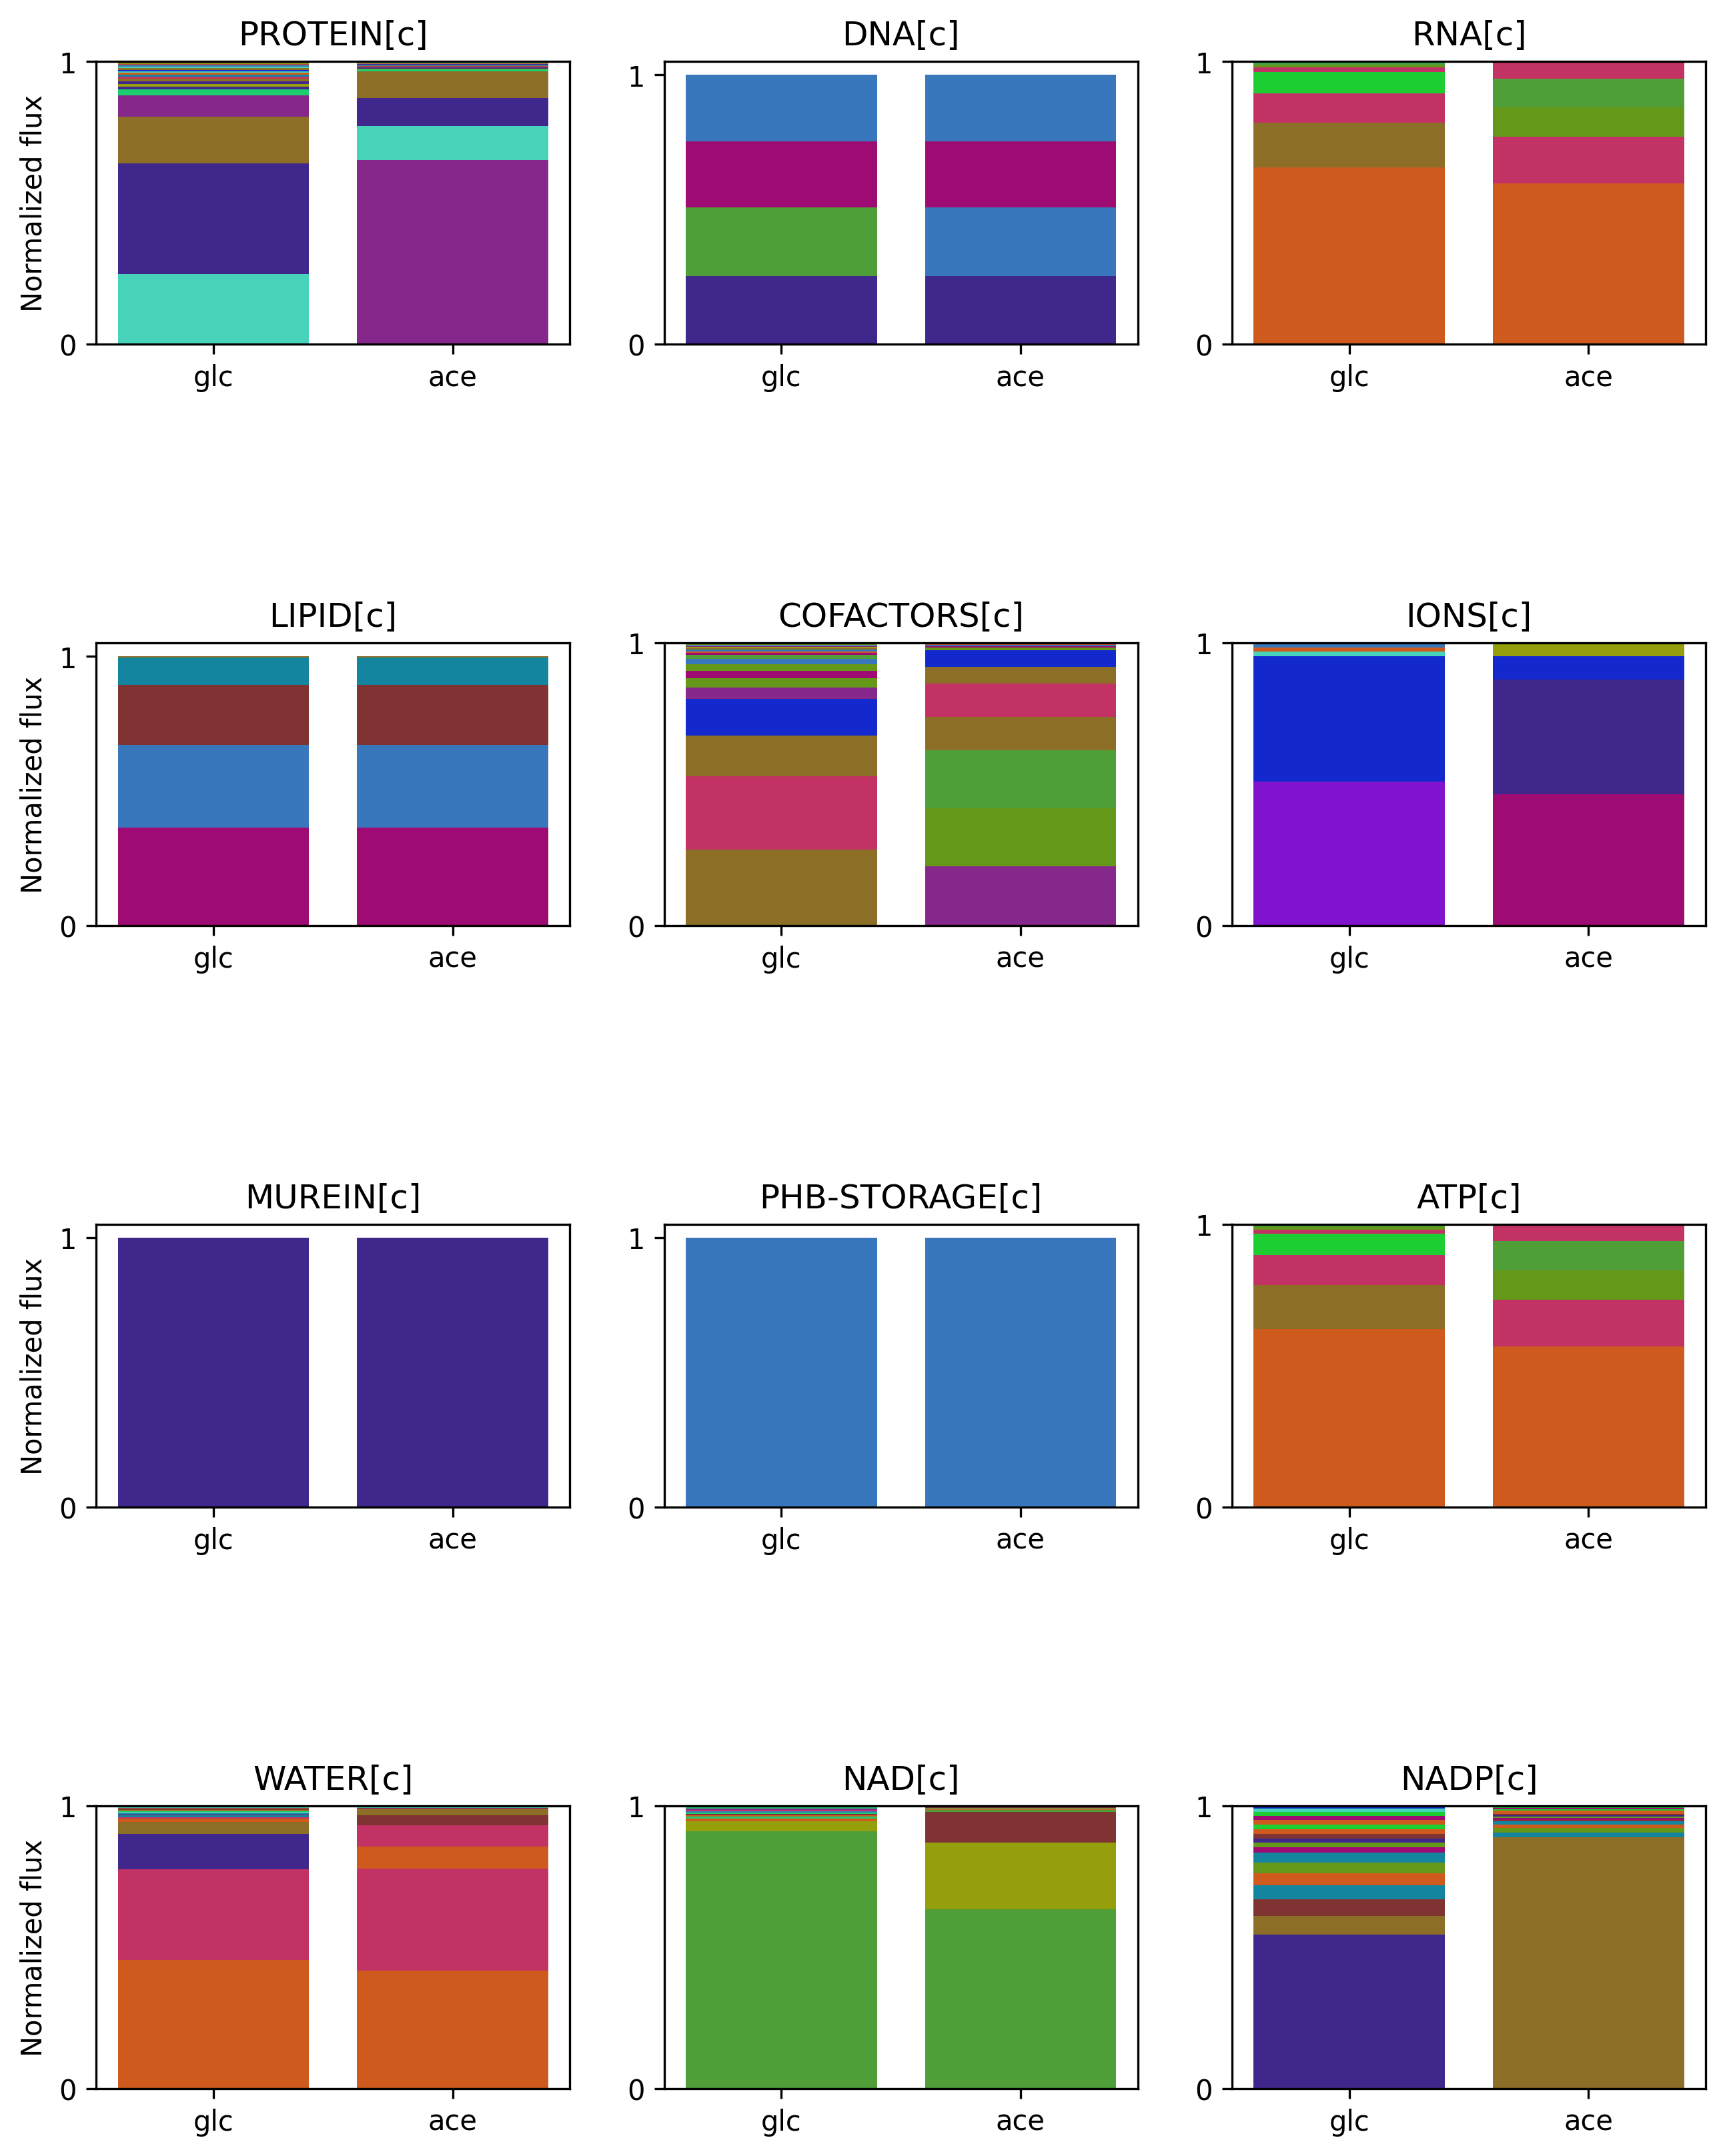

In [18]:
def production_comparison_plot(component, *flux_vectors, exclude_precursors=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    if exclude_precursors is None:
        exclude_precursors = []
    
    # Get producing fluxes
    producing_fluxes = [get_producing_fluxes(component, fluxes, exclude_precursors=exclude_precursors) for fluxes in flux_vectors]

    # Get producing reaction ids and fluxes for each vector,
    # Normalizing fluxes to sum to 1
    reaction_ids = [list(producing_flux_set.keys()) for producing_flux_set in producing_fluxes]
    fluxes = [np.array(list(producing_flux_set.values())) / sum(producing_flux_set.values())
              for producing_flux_set in producing_fluxes]

    # Sort by flux
    for i in range(len(flux_vectors)):
        reaction_ids[i] = sorted(reaction_ids[i], key=lambda x: producing_fluxes[i][x], reverse=True)
        fluxes[i] = sorted(fluxes[i], reverse=True)

    # Plot, stacking bars
    for x, (prod_reactions, prod_fluxes) in enumerate(zip(reaction_ids, fluxes)):
        total = 0
        for reaction_id, flux in zip(prod_reactions, prod_fluxes):
            ax.bar(x,
                   flux,
                   bottom=total,
                   label=reaction_id,
                   color=name_to_color(reaction_id))
            total += flux

biomass_requirements = [met for met, coeff in model.reactions.get_by_id("Rpom_hwa_biomass").metabolites.items() if coeff < 0]

width, height = nearest_rect(len(biomass_requirements))
fig, axs = plt.subplots(height, width, dpi=300.)

for i, met in enumerate(biomass_requirements):
    production_comparison_plot(met, glc_sol.fluxes, ace_sol.fluxes, exclude_precursors=["ATP[c]"] if met.id != "RNA[c]" else None, ax = axs.flat[i])
    axs.flat[i].set_title(met.id)
    axs.flat[i].set_xticks([0, 1], ["glc", "ace"])
    axs.flat[i].set_yticks([0, 1])

for ax in axs[:,0]:
    ax.set_ylabel("Normalized flux")

fig.tight_layout()
fig.set_size_inches(3 * width, 3 * height)

In [25]:
glc_sol.fluxes["ASPARTASE-RXN"]

-2.3485164266022833

In [32]:
print("DNA glucose =====================")

print(sorted(get_producing_fluxes(model.metabolites.get_by_id("DNA[c]"), glc_sol.fluxes, exclude_precursors=["ATP[c]"]).items(),
       key=lambda x: x[1],
       reverse=True))

print("DNA acetate =====================")

print(sorted(get_producing_fluxes(model.metabolites.get_by_id("DNA[c]"), ace_sol.fluxes, exclude_precursors=["ATP[c]"]).items(),
       key=lambda x: x[1],
       reverse=True))

DNA glucose =====================
[('DCDPKIN-RXN', 0.019424784864038237), ('RXN-14207', 0.019424784864038237), ('DADPKIN-RXN', 0.018812929663789866), ('RXN0-5107', 0.018812929663789862)]
DNA acetate =====================
[('DCDPKIN-RXN', 0.0035563094477923337), ('DGDPKIN-RXN', 0.0035563094477923337), ('DADPKIN-RXN', 0.0034442903729580703), ('RXN0-5107', 0.00344429037295807)]


In [36]:
print("NADP glucose =====================")

print(sorted(get_producing_fluxes(model.metabolites.get_by_id("NADP[c]"), glc_sol.fluxes, exclude_precursors=["ATP[c]"]).items(),
       key=lambda x: x[1],
       reverse=True))

print("NADP acetate =====================")

print(sorted(get_producing_fluxes(model.metabolites.get_by_id("NADP[c]"), ace_sol.fluxes, exclude_precursors=["ATP[c]"]).items(),
       key=lambda x: x[1],
       reverse=True))

NADP glucose =====================
[('1.4.1.21-RXN-L-ASPARTATE/NADP/WATER//OXALACETIC_ACID/AMMONIUM/NADPH/PROTON.62.', 6.782469514070123), ('RXN-8957', 0.8158832572454934), ('SHIKIMATE-5-DEHYDROGENASE-RXN', 0.714346056251791), ('ASPARTATE-SEMIALDEHYDE-DEHYDROGENASE-RXN', 0.6226688176522714), ('ACETOLACTREDUCTOISOM-RXN', 0.522401039649265), ('N-ACETYLGLUTPREDUCT-RXN', 0.48415007749487404), ('SULFITE-REDUCT-RXN', 0.44132509569386147), ('THIOREDOXIN-REDUCT-NADPH-RXN', 0.22358379428694475), ('RXN-9540', 0.1999177543922559), ('RXN-9536', 0.19991775439225587), ('RXN-9532', 0.19991775439225562), ('RXN-9528', 0.1999177543922556), ('RXN-9514', 0.1999177543922556), ('RXN-9524', 0.19991775439225556), ('RXN-9518', 0.19991775439225556), ('ACETOOHBUTREDUCTOISOM-RXN', 0.17357622580295412), ('GLUTSEMIALDEHYDROG-RXN', 0.1320690625193683), ('GLYC3PDEHYDROGBIOSYN-RXN-GLYCEROL-3P/NADP//DIHYDROXY-ACETONE-PHOSPHATE/NADPH/PROTON.59.', 0.09995887719613947), ('RXN-8850', 0.018812929663789862), ('RXN-17897', 0.

In [ ]:
model.reactions.get_by_id("RXN-14207").notes

{'EC Number': '2.7.1.40', 'Kegg ID': 'R01858', 'stem': 'RXN-14207'}

In [28]:
sorted(get_producing_fluxes(model.metabolites.get_by_id("PROTEIN[c]"), glc_sol.fluxes, exclude_precursors=["ATP[c]"]).items(),
       key=lambda x: x[1],
       reverse=True)

[('ASPAMINOTRANS-RXN', 7.7141455093661655),
 ('1.4.1.21-RXN-L-ASPARTATE/NADP/WATER//OXALACETIC_ACID/AMMONIUM/NADPH/PROTON.62.',
  6.782469514070123),
 ('RXN0-5114', 5.453600469969531),
 ('GLYOHMETRANS-RXN', 5.135627613841343),
 ('ASPARTASE-RXN', 2.3485164266022833),
 ('L-GLN-FRUCT-6-P-AMINOTRANS-RXN-FRUCTOSE-6P/GLN//CPD-13469/GLT.31.',
  0.6792308772051783),
 ('RXN-8', 0.3074294783187237),
 ('GABATRANSAM-RXN', 0.30742947831872364),
 ('ASNSYNB-RXN', 0.28803607985190594),
 ('BRANCHED-CHAINAMINOTRANSFERLEU-RXN', 0.2691692416962944),
 ('BRANCHED-CHAINAMINOTRANSFERVAL-RXN', 0.2528176633146266),
 ('DIAMINOPIMDECARB-RXN', 0.20502115536795643),
 ('ARGSUCCINLYA-RXN', 0.17672059917606456),
 ('BRANCHED-CHAINAMINOTRANSFERILEU-RXN', 0.17357622580295412),
 ('THRESYN-RXN', 0.15156501427423225),
 ('PYRROLINECARBREDUCT-RXN-PRO/NAD//L-DELTA1-PYRROLINE_5-CARBOXYLATE/NADH/PROTON.54.',
  0.1320690625193683),
 ('FGAMSYN-RXN', 0.12026145755187793),
 ('PRPPAMIDOTRANS-RXN', 0.12026145755187793),
 ('2.6.1.57-RX

In [20]:
sorted(get_producing_fluxes(model.metabolites.get_by_id("RNA[c]"), ace_sol.fluxes, exclude_precursors=[]).items(),
       key=lambda x: x[1],
       reverse=True)

[('ATPSYN-RXN', 35.097023258175774),
 ('PYRUVATEORTHOPHOSPHATE-DIKINASE-RXN', 10.252703706554092),
 ('MALATE--COA-LIGASE-RXN', 6.394560184990452),
 ('SUCCCOASYN-RXN', 6.339765638299946),
 ('FORMATETHFLIG-RXN', 3.6093093280539095),
 ('ADENYL-KIN-RXN', 0.0481063681420717),
 ('GDPKIN-RXN', 0.028823870378593446),
 ('CDPKIN-RXN', 0.01513452443652905),
 ('UDPKIN-RXN', 0.01402689505851517),
 ('CTPSYN-RXN', 0.00849905596311996),
 ('4.2.1.93-RXN', 2.7117710675443566e-15)]

In [21]:
model.reactions.get_by_id("RNA-RXN")

Reaction identifier,RNA-RXN
Name,RNA-RXN
Memory address,0x7fcd009a78f0
Stoichiometry,0.880652677 ATP[c] + 0.401180745 CTP[c] + 0.646346089 GTP[c] + 0.433020869 UTP[c] --> 0.35529704 ADP[c] + 2.00590334 PPI[c] + 0.35529704 PROTON[c] + 0.35529704 Pi[c] + RNA[c] 0.880652677 ATP + 0.401180745 CTP + 0.646346089 GTP + 0.433020869 UTP --> 0.35529704 ADP + 2.00590334 diphosphate + 0.35529704 H+ + 0.35529704 phosphate +
GPR,
Lower bound,0.0
Upper bound,1000.0


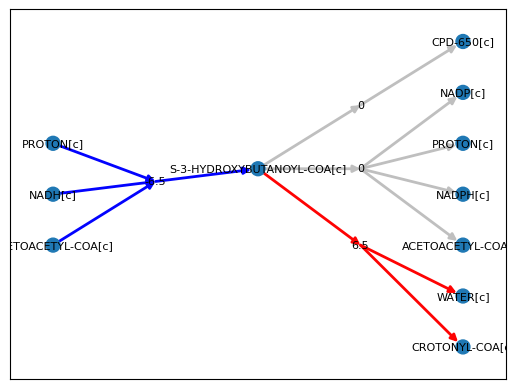

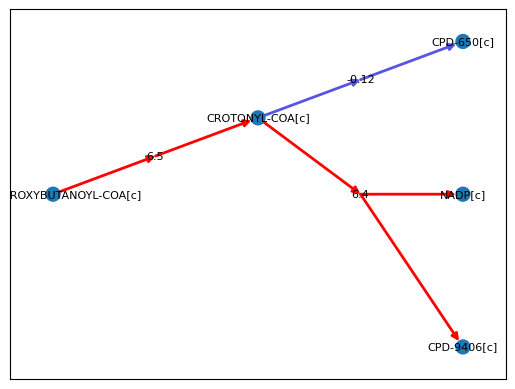

In [22]:
with model:
    ex_ace.lower_bound = -10
    sol = model.optimize()
    plot_metabolite_fluxes(model, "S-3-HYDROXYBUTANOYL-COA[c]")
    plot_metabolite_fluxes(model, "CROTONYL-COA[c]", include_zeros=False)